# Good Film // Bad Film
## Film Plot Synopses and etc. as Predictors of Critical Reception

This notebook builds and evaluates a handful of regression models which predict critical reception scores for films. Independent variables include plot synopsis free text, social media metrics on the leading actors, and other categorical variables such as film genre.

In [1]:
import os
import time
import pickle

import requests
from pycountry import languages

import pandas as pd
import numpy as np
from scipy.stats import boxcox

import matplotlib.pyplot as plt

# Data Collection

## Kaggle Dataset

From https://www.kaggle.com/tmdb/tmdb-movie-metadata:

In [ ]:
# kaggle_data = pd.read_csv('../data/imdb_5000_movies.csv') # Just a big Kaggle dataset full of movies.

In [ ]:
# kaggle_data.shape

## Extra Metadata from TheMovieDB.org

One good thing about this dataset is that it provides the unique IMdB movie ID's, which we can pass to a third-party API in order to supplement our data with more features. Here we parse out those IMdB ID's:

In [ ]:
# kaggle_data.tail()

Grab IMdB ID numbers for each film and append to dataframe:

In [ ]:
# imdb_ids = kaggle_data['movie_imdb_link'].str[26:35]
# imdb_ids[3000:3005]

In [ ]:
# kaggle_data['imdb_ids'] = imdb_ids

Here we make the API calls, and persist our data to little .json files:

In [ ]:
# You will need to enter your own API key in the API_KEY.py file (remove the .template suffix)
from API_KEY import API_KEY

try:
    os.mkdir('../data/movie_metadata')
except FileExistsError:
    pass

__This will make lots of API calls, be warned and use sparingly__, to avoid burning out your API key

In [ ]:
# i=0; j=0; total=len(imdb_ids)

# for id in imdb_ids:
#     print(f"Downloading movie {i} of {total}...")
#     i+=1
#     query_string = f'https://api.themoviedb.org/3/movie/{id}?api_key={API_KEY}'
#     json = requests.get(query_string).text
#     if "could not be found" in json:
#         j+=1
#         print(f"{round(j/i, 2)}% of movies not found")
#         continue
#     f = open(f'../data/movie_metadata/movie_{id}.json', 'w+')
#     f.write(json)
#     f.close()

## Combine Kaggle Dataset and TheMovieDB API Responses

In [ ]:
# tmdb_movies = pd.DataFrame()

# for filename in os.listdir(path='../data/movie_metadata/'):
#     if "movie" in filename:
#         this_movie = pd.read_json(f"../data/movie_metadata/{filename}", lines=True)
#         tmdb_movies = pd.concat([this_movie,tmdb_movies], axis=0)

# tmdb_movies = tmdb_movies.reset_index(drop=True)

In [ ]:
# df_merged = tmdb_movies.merge(kaggle_data, 
#                               how='left',
#                               left_on='imdb_id',
#                               right_on='imdb_ids',
#                               suffixes=("_kaggle","_api"))

# Data Cleaning and EDA

## Keep only interesting columns

In [ ]:
# df_merged.columns.tolist()

In [ ]:
# desired_cols = ("duration adult budget_api budget_kaggle language original_language "
#                 "production_countries runtime spoken_languages color genres_api "
#                 "title movie_title original_title overview content_rating "
#                 "actor_1_facebook_likes actor_2_facebook_likes actor_3_facebook_likes "
#                 "director_facebook_likes cast_total_facebook_likes facenumber_in_poster "
#                 "aspect_ratio imdb_score revenue").split()

In [ ]:
# df_lesscols = df_merged[desired_cols]
# df_lesscols.head()

In [ ]:
# df_lesscols.to_pickle("../data/pickles/df_lesscols.pkl")

## Null Values Management

In [ ]:
df_lesscols = pd.read_pickle("../data/pickles/df_lesscols.pkl")
df_lesscols.head(3)

Here are all of the truly "null" values:

In [ ]:
nulls = df_lesscols.isna().sum()[df_lesscols.isna().sum() > 0].sort_values(ascending=False)

nulls.plot(kind='bar', figsize=(15,8)).plot()

Gotta start somewhere.

### Budget

We have two disparate budget columns to draw from. We want whatever seems most plausible.

In [ ]:
df_lesscols[["budget_api", "budget_kaggle"]].head(10)

Lots of nulls in budget_api, lots of zeroes in budget_kaggle. How best to handle this? And are there other columns where we just have a bunch of zero values instead of nulls (revenue??)

In [ ]:
def best_guess_budget(row):
    # When budget_api is NaN and budget_kaggle is non-zero, take budget_kaggle.
    if row.isna()["budget_api"] and row['budget_kaggle'] != 0:
        return row['budget_kaggle']
    
    # When budget_api is not NaN but budget_kaggle is zero, take budget_api.
    elif not row.isna()["budget_api"] and row['budget_kaggle'] == 0:
        return row['budget_api']
    
    # When both values are not NaN / non-zero, take the mean?
    elif not row.isna()["budget_api"] and row['budget_kaggle'] != 0:
        return np.mean((row['budget_kaggle'], row['budget_api']))
        
    # When budget_api is NaN AND budget_kaggle is zero...that's tough. Maybe drop row. Consider imputing values?
    else:
        return None

In [ ]:
df_lesscols.head(10).apply(best_guess_budget, axis=1)

This is the desired behavior.

In [ ]:
best_budget = df_lesscols.apply(best_guess_budget, axis=1)

In [ ]:
df_best_guess_budget = df_lesscols.assign(best_budget=best_budget
                                         ).drop("budget_api budget_kaggle".split(), axis=1)

In [ ]:
df_best_guess_budget.best_budget.isna().mean()

5% of budget values are missing. I think I will in fact impute the median.

In [ ]:
budget_med = df_best_guess_budget.best_budget.dropna().median()
budget_mean = df_best_guess_budget.best_budget.dropna().mean()
budget_med, budget_mean

In [ ]:
df_filled_budget = df_best_guess_budget.assign(
    filled_budget = df_best_guess_budget["best_budget"].fillna(budget_med)
).drop(["best_budget"],axis=1)

In [ ]:
df_filled_budget.filled_budget.isna().mean()

In [ ]:
df_filled_budget.filled_budget.median(), df_filled_budget.filled_budget.mean()

This doesn't seem to have shifted the mean much, that's good.

### Aspect Ratio

In [ ]:
df_filled_budget.aspect_ratio.isna().mean()

6% of aspect ratios are null.

This is a categorical describing the dimensions of the projected image. Your TV set is 16x9 aka 1.77 aspect ratio, whereas lots of hollywood films are 1.85 ratio or 2.40, much "wider-screen". 2.40 might be "artsier".

In [ ]:
# Aspect ratio of 16 I take to mean 16x9 aka 1.77:
df_filled_budget.aspect_ratio = df_filled_budget.aspect_ratio.apply(lambda x: 1.77 if x==16 else x)
df_filled_budget.aspect_ratio.value_counts().sort_index().plot(kind="bar")

I think I will lump some of these together and impute 1.85 on null values. It's not *quite* the mode but it's a sort of middle-of-the road aspect ratio. The DCI standard lists 2.39 and 1.85 for theatrical projection. 16x9 or 1.77 is also common, and 4/3 or 1.33 is like an old-timey boxey aspect ratio.

In [ ]:
aspect_bins = [0, np.mean((1.33, 1.77)), np.mean((1.77,1.85)), np.mean((1.85,2.39)), np.inf]
aspect_labels = "1.33 1.77 1.85 2.39".split()

In [ ]:
pd.cut(df_filled_budget.aspect_ratio, 
       bins=aspect_bins, 
       labels=aspect_labels,
       include_lowest=True)

Lump values and impute 1.85:

In [ ]:
df_fixed_aspect = df_filled_budget.assign(fixed_aspect = pd.cut(df_filled_budget.aspect_ratio, 
                                                         bins=aspect_bins, 
                                                         labels=aspect_labels,
                                                         include_lowest=True
                                                               ).fillna("1.85")
                                         ).drop(["aspect_ratio"],axis=1)

In [ ]:
df_fixed_aspect.fixed_aspect.value_counts().sort_index().plot(kind="bar")

### Content Rating

In [ ]:
df_fixed_aspect.content_rating.isna().mean()

In [ ]:
df_fixed_aspect.content_rating.value_counts().plot(kind="bar")

Just gonna fill nulls with PG-13 and condense redundant ones

In [ ]:
df_content_rating_filled = df_fixed_aspect.assign(
                                content_rating=df_fixed_aspect.content_rating.fillna("PG-13")
                           )

In [ ]:
def rating_mapper(rating):
    if rating == "Not Rated":
        return "Unrated"
    elif rating in "Approved Passed M TV-14".split():
        return "PG-13"
    elif rating in "TV-G GP G TV-PG".split():
        return "PG"
    elif rating in ["NC-17"]:
        return "X"
    else:
        return rating

In [ ]:
df_content_rating_condensed = df_content_rating_filled.assign(
                                content_rating = df_content_rating_filled.content_rating.map(rating_mapper)
                              )

In [ ]:
df_content_rating_condensed.content_rating.value_counts().plot(kind="bar")

In [ ]:
df_content_rating_condensed.content_rating.isna().mean()

How are we doing on null values globally?

In [ ]:
nulls_update = df_content_rating_condensed.isna().sum()[
    df_content_rating_condensed.isna().sum() > 0
].sort_values(ascending=False)

nulls_update.plot(kind='bar', figsize=(15,8), rot=45).plot()

Clearing some memory:

In [ ]:
# del nulls
# del imdb_ids
# del kaggle_data
del best_budget
del df_lesscols
del df_best_guess_budget
del df_filled_budget
del df_content_rating_filled
del df_fixed_aspect

### Facebook Like Counts

In [ ]:
facebook_like_cols = [col for col in df_content_rating_condensed if "facebook" in col]
likes = df_content_rating_condensed[facebook_like_cols]

df_content_rating_condensed.drop(facebook_like_cols, axis=1, inplace=True)

likes.head()

In [ ]:
(round(likes.isna().mean()*100,2)).sort_values(ascending=False).astype('str')+"%"

Not that many values are missing. Will just use the medians.

In [ ]:
likes.fillna({col:likes[col].median() for col in likes.columns}, inplace=True)

In [ ]:
df_likes_filled = pd.concat([df_content_rating_condensed,
                             likes], axis=1)

In [ ]:
del df_content_rating_condensed
del likes

Time for another check-in:

In [ ]:
nulls_update = df_likes_filled.isna().sum()[
    df_likes_filled.isna().sum() > 0
].sort_values(ascending=False)

nulls_update.plot(kind='bar', figsize=(15,8), rot=45).plot()

del nulls_update

### Color

In [ ]:
df_likes_filled.color = df_likes_filled.color.str.lstrip()
df_likes_filled.color.value_counts()

Seems safe to assume that the last dozen films are in color...

In [ ]:
df_likes_filled.color = df_likes_filled.color.fillna(df_likes_filled.color.mode()[0])
df_color_filled = df_likes_filled.copy()

In [ ]:
del df_likes_filled

In [ ]:
df_color_filled.head(3)

In [ ]:
df_color_filled.color.isna().mean()

### Face Number in Poster

In [ ]:
df_color_filled.facenumber_in_poster.value_counts().plot(kind='bar')

Zero seems to be a placeholder for "idk" in this dataset, I'll drop this column.

In [ ]:
df_no_facenums = df_color_filled.drop(['facenumber_in_poster'],axis=1)
del df_color_filled
df_no_facenums.head()

### Language ("original... spoken... language")

In [ ]:
langs = df_no_facenums[[col for col in df_no_facenums.columns if "language" in col]]
langs.head(15)

In [ ]:
langs.isna().mean()

In [ ]:
df_no_facenums.loc[13]

The "language" column looks not great. "original language" is probably a better bet.

In [ ]:
df_no_facenums.spoken_languages.tail()

In [ ]:
df_no_facenums.original_language.tail()

Yeah I think that's probably the best column.

In [ ]:
df_no_facenums.original_language.value_counts().head(10)

Using a python package to make language codes human-readable:

In [ ]:
lang_decoder = {lang.alpha_2: lang.name for lang in languages if hasattr(lang,'alpha_2')}
list(lang_decoder.items())[:5]

In [ ]:
df_no_facenums.original_language = df_no_facenums.original_language.map(lang_decoder)
df_no_facenums.original_language.value_counts()[2:].plot(kind='bar')

Just eyeballing it...I think anything after German, in terms of frequency, is gonna have to go in "other"

Grabbing most popular languages:

In [ ]:
top_langs = df_no_facenums.original_language.value_counts().index[:3].tolist()
top_langs

In [ ]:
def language_lumper(lang):
    if lang not in top_langs:
        return "Other"
    else:
        return lang

In [ ]:
df_no_facenums.original_language = df_no_facenums.original_language.apply(language_lumper)

In [ ]:
df_langs_lumped = df_no_facenums.drop("language spoken_languages".split(),axis=1)
del df_no_facenums
del langs

In [ ]:
df_langs_lumped.head()

In [ ]:
df_langs_lumped.original_language.value_counts().plot(kind='bar')

***

In [ ]:
nulls = df_langs_lumped.isna().sum()[df_langs_lumped.isna().sum() > 0].sort_values(ascending=False)

nulls.plot(kind='bar', figsize=(15,8)).plot()

del nulls

### Duration / Runtime

In [ ]:
durs = df_langs_lumped["duration runtime".split()]
durs.head()

How different are these columns?

In [ ]:
(durs.duration - durs.runtime).plot(kind='hist')
(durs.duration - durs.runtime).mean()

Not very.

In [ ]:
df_langs_lumped.drop(["duration"],axis=1,inplace=True)

In [ ]:
df_runtimes_filled = df_langs_lumped.assign(
    durations=df_langs_lumped.runtime.fillna(
        df_langs_lumped.runtime.median()
    )
).drop(["runtime"],axis=1)

del df_langs_lumped
del durs

In [ ]:
df_runtimes_filled.isna().mean()

**No more obvious nulls!**

In [ ]:
# df_runtimes_filled.to_pickle("../data/pickles/df_no_nulls.pkl")

## Column Inspection: Categoricals

In [62]:
df_no_nulls = pd.read_pickle("../data/pickles/df_no_nulls.pkl")
df_no_nulls.columns.tolist()

['adult',
 'original_language',
 'production_countries',
 'color',
 'genres_api',
 'title',
 'movie_title',
 'original_title',
 'overview',
 'content_rating',
 'imdb_score',
 'revenue',
 'filled_budget',
 'fixed_aspect',
 'actor_1_facebook_likes',
 'actor_2_facebook_likes',
 'actor_3_facebook_likes',
 'director_facebook_likes',
 'cast_total_facebook_likes',
 'durations']

### "Adult"

In [63]:
df_no_nulls.adult.value_counts()

False    4925
Name: adult, dtype: int64

Single-value column. Drop it

In [64]:
df_no_adult = df_no_nulls.drop(["adult"],axis=1)
del df_no_nulls

In [65]:
# df_no_adult.columns.tolist()

### Production Countries

In [66]:
df_no_adult['production_countries'].head()

0        [{'iso_3166_1': 'KR', 'name': 'South Korea'}]
1             [{'iso_3166_1': 'FR', 'name': 'France'}]
2    [{'iso_3166_1': 'US', 'name': 'United States o...
3        [{'iso_3166_1': 'KR', 'name': 'South Korea'}]
4    [{'iso_3166_1': 'US', 'name': 'United States o...
Name: production_countries, dtype: object

Hmm list of dict. Let's just grab the human-readable names:

In [67]:
def prod_countries_extractor(countries):
    if len(countries)!=0:
        return {country['name'] for country in countries}
    else:
        return {}

In [68]:
df_no_adult.production_countries = df_no_adult.production_countries.apply(prod_countries_extractor)

In [69]:
df_no_adult.production_countries.loc[29:34]

29                      {France, Spain, Belgium}
30                    {United States of America}
31                                            {}
32    {United Kingdom, United States of America}
33                                       {Japan}
34                                       {Japan}
Name: production_countries, dtype: object

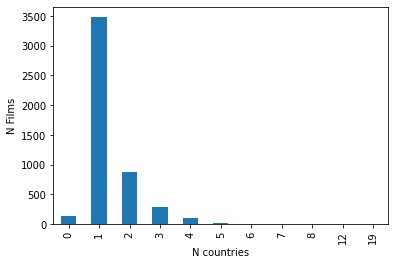

In [70]:
# Turns out pandas vectorized string operations work on lists too
ax = df_no_adult.production_countries.str.len().value_counts().sort_index().plot(kind='bar')
ax.set_xlabel("N countries")
ax.set_ylabel("N Films")
ax.plot()
del ax

I feel like that ^ can become an int column, after the zeroes are fixed

In [71]:
# If it's not in English, can we guess where it was filmed?
df_no_adult[(
                df_no_adult.production_countries.str.len()==0
            )&(
                df_no_adult.original_language!="English"
            )]

,original_language,production_countries,color,genres_api,title,movie_title,original_title,overview,content_rating,imdb_score,revenue,filled_budget,fixed_aspect,actor_1_facebook_likes,actor_2_facebook_likes,actor_3_facebook_likes,director_facebook_likes,cast_total_facebook_likes,durations
480,Other,{},Color,Documentary|News,Food Chains,Food Chains,Food Chains,,PG-13,7.1,0,913000.0,1.85,56.0,28.0,17.0,0.0,104,83.0
2051,Other,{},Color,Horror|Thriller,The Tooth Fairy,The Tooth Fairy,The Tooth Fairy,A woman and her daughter (Nicole Muñoz) encoun...,PG-13,4.6,0,1500000.0,1.77,598.0,555.0,235.0,42.0,2353,89.0
2260,Other,{},Color,Action|Adventure|Romance|Sci-Fi,Krrish,Krrish,कृष,"In Singapore, Krishna is forced by circumstanc...",Unrated,6.3,0,10000000.0,2.39,307.0,200.0,45.0,53.0,616,174.0
3242,Other,{},Color,Action|Comedy|Romance|Thriller,Hum To Mohabbat Karega,Hum To Mohabbat Karega,Hum To Mohabbat Karega,A man lies about being an eyewitness to a murd...,PG-13,2.8,0,19500000.0,1.85,353.0,89.0,72.0,4.0,613,148.0


In [72]:
guesses = {480:"Germany", 
           2051:"Germany",
           2260:"India",
           3242:"India"}

for index, country in guesses.items():
    df_no_adult['production_countries'].loc[index] = country
    
del index
del country

/Users/admin/.local/share/virtualenvs/Good-Film-Bad-Film-vaMlpeB4/lib/python3.7/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [73]:
df_no_adult.loc[guesses.keys()]

,original_language,production_countries,color,genres_api,title,movie_title,original_title,overview,content_rating,imdb_score,revenue,filled_budget,fixed_aspect,actor_1_facebook_likes,actor_2_facebook_likes,actor_3_facebook_likes,director_facebook_likes,cast_total_facebook_likes,durations
480,Other,Germany,Color,Documentary|News,Food Chains,Food Chains,Food Chains,,PG-13,7.1,0,913000.0,1.85,56.0,28.0,17.0,0.0,104,83.0
2051,Other,Germany,Color,Horror|Thriller,The Tooth Fairy,The Tooth Fairy,The Tooth Fairy,A woman and her daughter (Nicole Muñoz) encoun...,PG-13,4.6,0,1500000.0,1.77,598.0,555.0,235.0,42.0,2353,89.0
2260,Other,India,Color,Action|Adventure|Romance|Sci-Fi,Krrish,Krrish,कृष,"In Singapore, Krishna is forced by circumstanc...",Unrated,6.3,0,10000000.0,2.39,307.0,200.0,45.0,53.0,616,174.0
3242,Other,India,Color,Action|Comedy|Romance|Thriller,Hum To Mohabbat Karega,Hum To Mohabbat Karega,Hum To Mohabbat Karega,A man lies about being an eyewitness to a murd...,PG-13,2.8,0,19500000.0,1.85,353.0,89.0,72.0,4.0,613,148.0


In [74]:
del guesses

In [75]:
df_no_adult.production_countries.value_counts().head(10)

TypeError: unhashable type: 'set'

Exception ignored in: 'pandas._libs.index.IndexEngine._call_map_locations'
Traceback (most recent call last):
  File "pandas/_libs/hashtable_class_helper.pxi", line 1653, in pandas._libs.hashtable.PyObjectHashTable.map_locations
TypeError: unhashable type: 'set'


{United States of America}                    3067
{United Kingdom, United States of America}     222
{Germany, United States of America}            139
{}                                             135
{United Kingdom}                               128
{Canada, United States of America}             107
{Australia, United States of America}           57
{France}                                        49
{Canada}                                        47
{France, United States of America}              43
Name: production_countries, dtype: int64

In [76]:
def fill_with_USA(country_set):
    return {"United States of America"} if country_set == {} else country_set

In [77]:
df_no_adult["production_countries"] = df_no_adult.production_countries.apply(fill_with_USA)

In [78]:
df_filled_USA = df_no_adult.copy()
del df_no_adult

Might need to split into USA and not-USA to deal with class imbalance

In [79]:
def usa_or_not(country_set):
    return True if country_set=={"United States of America"} else False

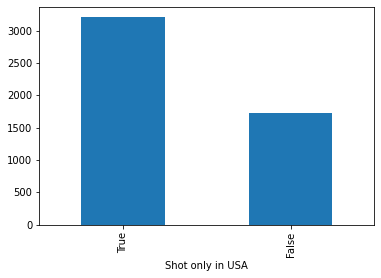

In [80]:
ax = df_filled_USA.production_countries.apply(usa_or_not).value_counts().plot(kind='bar')
ax.set_xlabel("Shot only in USA")
del ax

In [81]:
df_filled_USA['shot_only_in_USA'] = df_filled_USA.production_countries.apply(usa_or_not)

In [82]:
def shot_in_usa_and_abroad(country_set):
    if len(country_set)>1 and "United States of America" in country_set:
        return True
    else:
        return False

In [83]:
df_filled_USA['shot_in_USA_and_abroad'] = df_filled_USA.production_countries.apply(shot_in_usa_and_abroad)

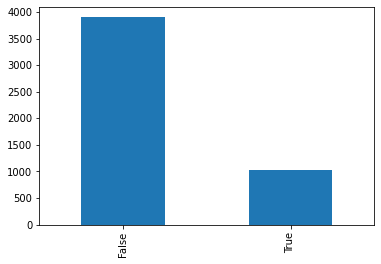

In [84]:
df_filled_USA['shot_in_USA_and_abroad'].value_counts().plot(kind='bar')

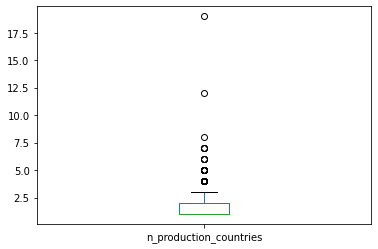

In [85]:
df_filled_USA['n_production_countries'] = df_filled_USA.production_countries.str.len()
df_filled_USA['n_production_countries'].plot(kind='box')

In [86]:
df_n_countries = df_filled_USA.drop(["production_countries"],axis=1)

In [87]:
del df_filled_USA

In [88]:
df_n_countries.columns.tolist()

['original_language',
 'color',
 'genres_api',
 'title',
 'movie_title',
 'original_title',
 'overview',
 'content_rating',
 'imdb_score',
 'revenue',
 'filled_budget',
 'fixed_aspect',
 'actor_1_facebook_likes',
 'actor_2_facebook_likes',
 'actor_3_facebook_likes',
 'director_facebook_likes',
 'cast_total_facebook_likes',
 'durations',
 'shot_only_in_USA',
 'shot_in_USA_and_abroad',
 'n_production_countries']

### Genre

In [89]:
df_n_countries['genre'] = df_n_countries['genres_api'].str.split("|")
df_n_countries['genre'] = df_n_countries['genre'].apply(lambda x: set(x))
del df_n_countries["genres_api"]

In [90]:
df_n_countries['genre'].apply(lambda x: set(x)).value_counts().head(20)

TypeError: unhashable type: 'set'

Exception ignored in: 'pandas._libs.index.IndexEngine._call_map_locations'
Traceback (most recent call last):
  File "pandas/_libs/hashtable_class_helper.pxi", line 1653, in pandas._libs.hashtable.PyObjectHashTable.map_locations
TypeError: unhashable type: 'set'


{Drama}                              232
{Comedy}                             200
{Comedy, Drama}                      189
{Comedy, Romance, Drama}             184
{Comedy, Romance}                    153
{Drama, Romance}                     149
{Crime, Drama, Thriller}              98
{Horror}                              71
{Crime, Action, Thriller}             65
{Crime, Drama, Action, Thriller}      64
{Drama, Thriller}                     63
{Crime, Drama}                        58
{Horror, Thriller}                    56
{Mystery, Crime, Drama, Thriller}     52
{Adventure, Action, Sci-Fi}           51
{Crime, Comedy}                       51
{Documentary}                         48
{Adventure, Action, Thriller}         46
{Mystery, Drama, Thriller}            36
{Mystery, Horror, Thriller}           35
Name: genre, dtype: int64

In [91]:
genre_cats = "Drama Comedy Romance Crime Thriller Horror Action Mystery Sci-Fi Adventure Documentary".split()

In [92]:
def genre_encoder(genre_set):
    new = pd.Series(False, index=genre_cats)
    for genre in genre_set:
        if genre in genre_cats:
            new[genre] = True
    return new

In [94]:
df_n_countries.genre.head()

0    {Fantasy, Horror, Mystery, Thriller}
1                         {Comedy, Drama}
2                           {Documentary}
3           {Drama, Action, History, War}
4                       {Comedy, Romance}
Name: genre, dtype: object

In [93]:
df_n_countries.genre.head().apply(genre_encoder)

,Drama,Comedy,Romance,Crime,Thriller,Horror,Action,Mystery,Sci-Fi,Adventure,Documentary
0,False,False,False,False,True,True,False,True,False,False,False
1,True,True,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,True
3,True,False,False,False,False,False,True,False,False,False,False
4,False,True,True,False,False,False,False,False,False,False,False


In [95]:
genre_matrix = df_n_countries.genre.apply(genre_encoder)

In [96]:
del df_n_countries['genre']

In [104]:
genre_matrix.columns = ["".join(["genre_", col]) for col in genre_matrix.columns.tolist()]

In [105]:
df_encoded_genres = pd.concat([df_n_countries,genre_matrix],axis=1)

In [106]:
del df_n_countries
del genre_matrix
del genre_cats

In [108]:
# df_encoded_genres.to_pickle("../data/pickles/df_encoded_genres.pkl")

## Column Inspection: Numericals

In [219]:
df_encoded_genres = pd.read_pickle("../data/pickles/df_encoded_genres.pkl")

In [220]:
# df_encoded_genres.columns.tolist()

### Facebook Likes

In [221]:
likes = df_encoded_genres[[col for col in df_encoded_genres.columns if "likes" in col]]
likes.head()

,actor_1_facebook_likes,actor_2_facebook_likes,actor_3_facebook_likes,director_facebook_likes,cast_total_facebook_likes
0,45.0,5.0,0.0,43.0,50
1,541.0,8.0,2.0,12.0,553
2,21.0,3.0,0.0,117.0,24
3,14000.0,81.0,29.0,32.0,14133
4,927.0,509.0,503.0,23.0,3552


In [222]:
likes.actor_1_facebook_likes.describe()

count      4925.000000
mean       6670.180508
std       15157.916837
min           0.000000
25%         622.000000
50%         995.000000
75%       11000.000000
max      640000.000000
Name: actor_1_facebook_likes, dtype: float64

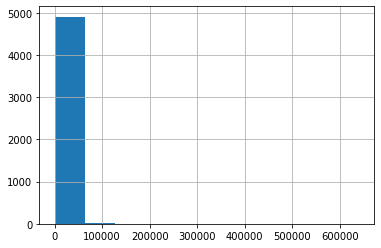

In [223]:
likes.actor_1_facebook_likes.hist()

Could probably use a log transform or something. Or is it just full of zeroes?

In [224]:
likes.actor_1_facebook_likes[likes.actor_1_facebook_likes < 5].shape

(36,)

In [225]:
likes.director_facebook_likes[likes.director_facebook_likes == 0].shape

(900,)

In [226]:
likes.director_facebook_likes.describe()

count     4925.000000
mean       688.347208
std       2817.108898
min          0.000000
25%          7.000000
50%         49.000000
75%        197.000000
max      23000.000000
Name: director_facebook_likes, dtype: float64

I'm willing to believe that directors are just generally not as popular as their actors

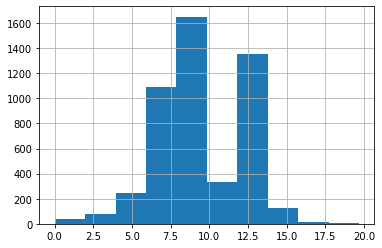

In [227]:
# +1 like for boxcox, does not like zeroes
pd.Series(boxcox(likes.actor_1_facebook_likes+1)[0]).hist()

Seems good

In [228]:
all_boxcoxed = [pd.Series(boxcox(likes[col]+1)[0], name=f"{col}_box") for col in likes.columns]

In [229]:
boxed_df = pd.concat(all_boxcoxed,axis=1)
boxed_df.head()

,actor_1_facebook_likes_box,actor_2_facebook_likes_box,actor_3_facebook_likes_box,director_facebook_likes_box,cast_total_facebook_likes_box
0,4.258068,1.915040,0.000000,3.664026,5.230433
1,7.512101,2.384509,1.196106,2.509361,10.112309
2,3.367098,1.459349,0.000000,4.580765,4.058610
3,12.528987,5.203700,4.459035,3.393753,19.946681
4,8.281601,7.907600,10.385821,3.093011,15.209840


actor_1_facebook_likes_box


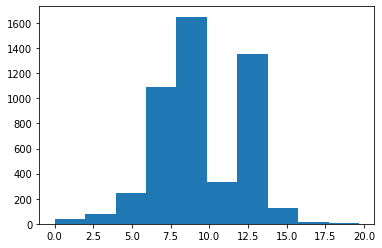

actor_2_facebook_likes_box


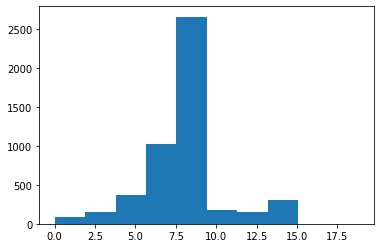

actor_3_facebook_likes_box


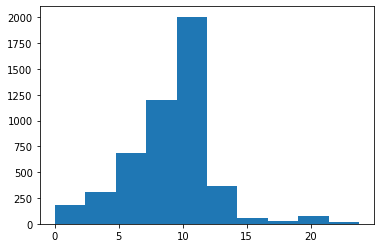

director_facebook_likes_box


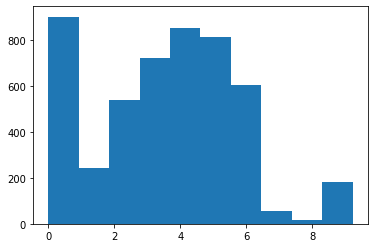

cast_total_facebook_likes_box


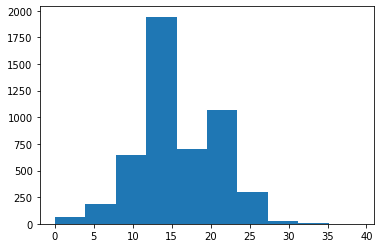

In [230]:
for col in boxed_df:
    plt.figure()
    plt.hist(boxed_df[col])
    print(col)
    plt.show()
del col

In [231]:
no_likes = df_encoded_genres.drop([col for col in df_encoded_genres if "likes" in col], axis=1)

In [232]:
df_boxcoxed_likes = pd.concat([no_likes, boxed_df],axis=1)

In [233]:
df_boxcoxed_likes.head(3)

,original_language,color,title,movie_title,original_title,overview,content_rating,imdb_score,revenue,filled_budget,...,genre_Action,genre_Mystery,genre_Sci-Fi,genre_Adventure,genre_Documentary,actor_1_facebook_likes_box,actor_2_facebook_likes_box,actor_3_facebook_likes_box,director_facebook_likes_box,cast_total_facebook_likes_box
0,Other,Color,The Wailing,The Wailing,곡성,A stranger arrives in a little village and soo...,Unrated,7.7,47098491,10951000.0,...,False,True,False,False,False,4.258068,1.915040,0.000000,3.664026,5.230433
1,French,Color,The Country Doctor,Irreplaceable,Médecin de campagne,"All the people in this countryside area, can c...",PG-13,7.2,0,19500000.0,...,False,False,False,False,False,7.512101,2.384509,1.196106,2.509361,10.112309
2,English,Color,Time to Choose,Time to Choose,Time to Choose,Academy Award® winning director Charles Fergus...,PG-13,7.0,0,3500000.0,...,False,False,False,False,True,3.367098,1.459349,0.000000,4.580765,4.058610


In [234]:
del df_encoded_genres
del no_likes
del all_boxcoxed
del boxed_df
del likes

### Budget

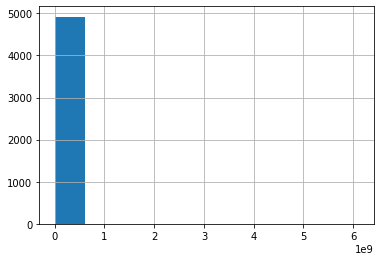

In [235]:
df_boxcoxed_likes.filled_budget.hist()

Also pretty skewed up

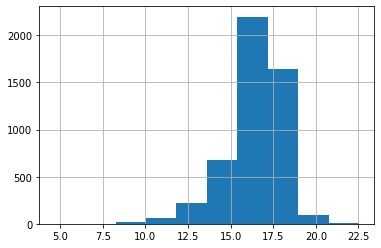

In [236]:
df_boxcoxed_likes.filled_budget.transform(np.log).hist()

Not perfect, boxcox again?

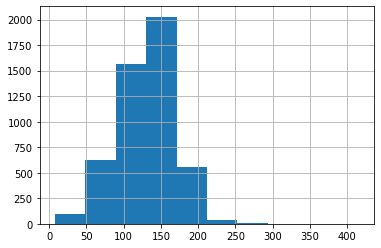

In [237]:
budget_boxed = pd.Series(boxcox(df_boxcoxed_likes.filled_budget)[0], name="budget_boxed")
budget_boxed.hist()

In [238]:
del df_boxcoxed_likes['filled_budget']

In [239]:
df_boxcoxed_budget = df_boxcoxed_likes.assign(budget_boxed=budget_boxed)

In [240]:
del budget_boxed
del df_boxcoxed_likes

### Duration

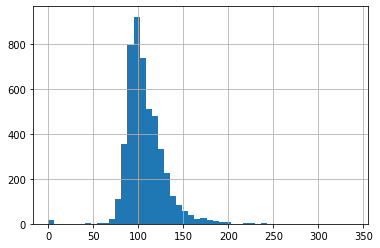

In [241]:
df_boxcoxed_budget.durations.hist(bins=50)

Seems pretty tightly clustered around feature length film length

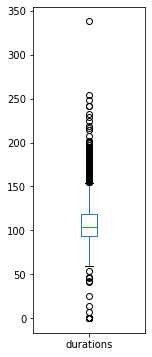

In [242]:
df_boxcoxed_budget.durations.plot(kind='box',figsize=(2,6))

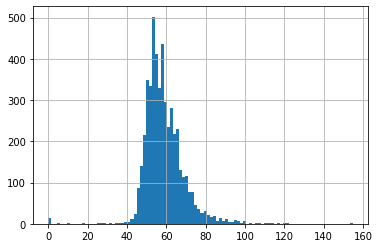

In [243]:
pd.Series(boxcox(df_boxcoxed_budget.durations+1)[0], name=f"duration_box").hist(bins=100)

I think we can just stick with the original durations, no transform needed.

### Number of Production Countries

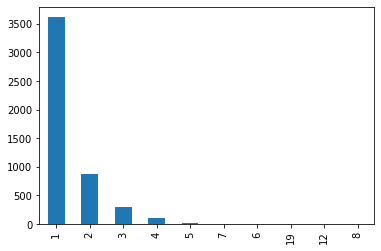

In [244]:
df_boxcoxed_budget.n_production_countries.value_counts().plot(kind='bar')

I should lump together 5+ perhaps...it gets a bit sparse

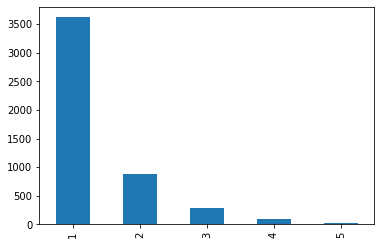

In [245]:
df_boxcoxed_budget.n_production_countries.apply(lambda x: 5 if x >= 5 else x).value_counts().plot(kind='bar')

In [246]:
df_boxcoxed_budget["n_prod_locs_trunc"] = df_boxcoxed_budget.n_production_countries.apply(
                                                                                    lambda x: 5 if x >= 5 else x
                                                                                )

We will need to remember that here, the int 5 represents 5 or more countries of filming.

In [247]:
del df_boxcoxed_budget["n_production_countries"]

### Revenue (Secondary Response Variable)

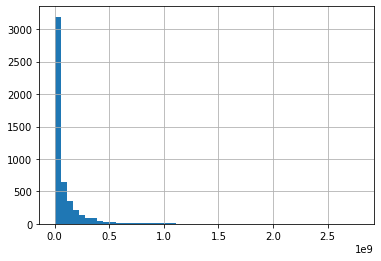

In [248]:
df_boxcoxed_budget.revenue.hist(bins=50)

In [249]:
revenue_boxcox, lambda_revenue_boxcox = boxcox(df_boxcoxed_budget.revenue+1) #Again applying small adjustment for box

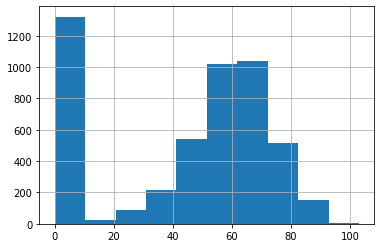

In [250]:
revenue_boxcox = pd.Series(revenue_boxcox,name="revenue_boxcox")
revenue_boxcox.hist()

Still a pretty massive spike around $0 revenue...will this be a problem?

In [251]:
del df_boxcoxed_budget['revenue']

In [252]:
df_boxcox_rev = df_boxcoxed_budget.assign(revenue_boxcox=revenue_boxcox)

In [253]:
del df_boxcoxed_budget

### IMdB Score (Response Variable)

In [254]:
df_boxcox_rev.imdb_score.describe()

count    4925.000000
mean        6.416975
std         1.115080
min         1.600000
25%         5.800000
50%         6.500000
75%         7.200000
max         9.300000
Name: imdb_score, dtype: float64

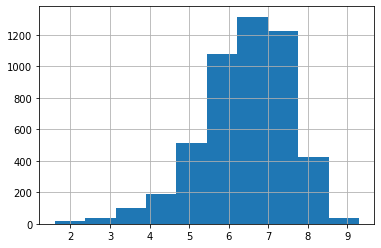

In [255]:
df_boxcox_rev.imdb_score.hist()

Nice!

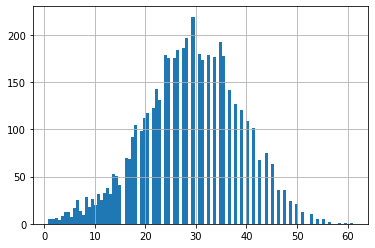

In [256]:
pd.Series(boxcox(df_boxcox_rev.imdb_score)[0], name="imdb_score_boxed").hist(bins=100)

In [257]:
imdb_score_boxed, lambda_imdb_score = boxcox(df_boxcox_rev.imdb_score)

In [258]:
df_boxcox_rev['imdb_score_boxed']=pd.Series(boxcox(df_boxcox_rev.imdb_score)[0], name="imdb_score_boxed")

In [259]:
del df_boxcox_rev['imdb_score']

In [262]:
# df_boxcox_rev.to_pickle("../data/pickles/df_boxcox_rev.pkl")

## Column Inspection: Free Text

In [263]:
df_boxcox_revenue = pd.read_pickle("../data/pickles/df_boxcox_rev.pkl")

### Titles

In [264]:
df_boxcox_revenue.head()

,original_language,color,title,movie_title,original_title,overview,content_rating,fixed_aspect,durations,shot_only_in_USA,...,genre_Documentary,actor_1_facebook_likes_box,actor_2_facebook_likes_box,actor_3_facebook_likes_box,director_facebook_likes_box,cast_total_facebook_likes_box,budget_boxed,n_prod_locs_trunc,revenue_boxcox,imdb_score_boxed
0,Other,Color,The Wailing,The Wailing,곡성,A stranger arrives in a little village and soo...,Unrated,2.39,156.0,False,...,False,4.258068,1.915040,0.000000,3.664026,5.230433,116.935937,1,60.259745,40.128255
1,French,Color,The Country Doctor,Irreplaceable,Médecin de campagne,"All the people in this countryside area, can c...",PG-13,1.85,102.0,False,...,False,7.512101,2.384509,1.196106,2.509361,10.112309,131.532585,1,0.000000,34.553970
2,English,Color,Time to Choose,Time to Choose,Time to Choose,Academy Award® winning director Charles Fergus...,PG-13,1.85,100.0,True,...,True,3.367098,1.459349,0.000000,4.580765,4.058610,92.507826,1,0.000000,32.449510
3,Other,Color,Operation Chromite,Operation Chromite,인천상륙작전,A squad of soldiers fight in the Korean War's ...,PG-13,1.85,111.0,False,...,False,12.528987,5.203700,4.459035,3.393753,19.946681,120.450934,1,60.616293,30.416024
4,English,Color,The Perfect Match,The Perfect Match,The Perfect Match,"Terrence J. stars as Charlie, a playboy who's ...",R,1.85,96.0,True,...,False,8.281601,7.907600,10.385821,3.093011,15.209840,99.568658,1,0.000000,11.989734


***

# Bivariate Analyses

Are there any redundant features? Are there any features obviously correlated with our dependent var?

In [ ]:
# Creating a multi-scatter plot
main_corr= main_df.drop(['binary_target'], axis=1).iloc[:,:]
pd.plotting.scatter_matrix(main_corr, figsize=[15,15]);

In [ ]:
sns.heatmap(main_corr.corr(), center=0);

# Structured-Only Linear Regression

Let's start without incorporating the unstructured text data, just numerical and categorical info:

Now that we've cleaned up a bit, we'll start throwing our features at a statsmodels logistic regression estimator to evaluate r^2 and p-values of various features.

In [ ]:
# check LogReg with all initial variables from main_df (note: no plot)
s = ("binary_target ~ Year + C(Action) + C(Adventure) + C(Animation) + C(Biography) + C(Comedy)"
                 "+ C(Crime) + C(Documentary) + C(Drama) + C(Family) + C(Fantasy) + C(History)"
                 "+ C(Horror) + C(Musical) + C(Mystery) + C(Romance) + C(Sci_Fi) + C(Sport)"
                 "+ C(Thriller) + C(War)+ C(Western)"
                 "+ Actor_1_fb_likes_logged + Actor_2_fb_likes_logged"
                 "+ Actor_3_fb_likes_logged")

y, X = dmatrices(s, main_df, return_type="dataframe")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size =  0.2)

logit_model = sm.Logit(y_train.iloc[:,0], X_train)
result = logit_model.fit()

print(result.summary())

y_preds = result.predict(X_test)

accuracy_score(y_test, y_preds >=.5)

This gives us an idea of which features might be less important in the determination of what makes a movie "good". We'll drop the less pertinent features and try again:

In [ ]:
s = ("binary_target ~ Year + C(Action) + C(Animation) + C(Biography) + C(Comedy)"
                 "+ C(Documentary) + C(Drama) + C(Family)"
                 "+ C(Horror) + C(Mystery) + C(Romance) + C(Sci_Fi)"
                 "+ C(Thriller)"
                 "+ Actor_1_fb_likes_logged + Actor_2_fb_likes_logged"
                 "+ Actor_3_fb_likes_logged")

main_df = main_df.drop(['Adventure','Crime', 'Fantasy', 'History', 'Musical', 'Sport', 'War', 'Western'], axis=1)

y, X = dmatrices(s, main_df, return_type = "dataframe")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size =  0.2)

logit_model = sm.Logit(y_train.iloc[:,0], X_train)
result = logit_model.fit()

print(result.summary())

y_preds = result.predict(X_test)

accuracy_score(y_test, y_preds >=.5)

In [ ]:
main_df.columns

These are the features we're sticking with for now.

It's fairly intuitive that the social media popularity of the leading actors would be positively correlated, but we'll leave it in in case there are deviations from that norm. It's interesting to note that films in the "animation" genre are so commonly also in the "family" genre. Makes sense too.

# Preparing Unstructured Features

## Lemmatize / Vectorize

In [ ]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def lemmatize(plot_list):
    lemmatized_plots = []
    
    for plot in plot_list:
        tokenized_lower = word_tokenize(plot.lower()) # Make plot summary lowercase and lemmatize        
        tokenized_lower =[word for word in tokenized_lower if english_d.check(word)] # Make sure it's an english word
        dirty_lemma = [lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in tokenized_lower] # Lemmatize
        dirty_lemma_string = ' '.join(dirty_lemma)
        
        # Filter out words that don't match this regex pattern:
        reg = re.compile((r"([a-zA-Z]+(?:'[a-z]+)?)"))
        lemmatized_regex = [word_lem for word_lem in dirty_lemma if word_lem in reg.findall(dirty_lemma_string)]
        
        # Remove stop words
        lemmatized = [word_lem for word_lem in lemmatized_regex if not word_lem in stop_words]
        lemmatized_string = ' '.join(lemmatized)
        lemmatized_plots.append(lemmatized_string)
        
    return lemmatized_plots

In [ ]:
def get_wordnet_pos(word):
    """Map POS tag to the first character that lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

### Run the Lemmatizer

In [ ]:
all_plots = [plot for plot in df.loc[:,'Plot'].values] # Get all movie plots.
plots = lemmatize(all_plots) # Lemmatize.

### Vectorizing Plots

In [ ]:
# Term frequency = Number of times a word appears in a document / number of words in document
# Inverse document frequency = log base e(number of documents / number of documents with word in it)
# tf:idf = tf * idf

tfidf = TfidfVectorizer()
response = tfidf.fit_transform(plots)
print(response.shape)

tfidf_df = pd.DataFrame(response.toarray(), columns=tfidf.get_feature_names())

Now we have all plots lemmatized as "plots" and vectorized / weighted as "tfidf_df".

## Topic Clustering with LDA

Gensim clusters words that appear together frequently. The clusters can be interpreted as general topics, and each movie gets weights indicating the degree to which it belongs to each topic. These weights are then re-incorporated as features in our dataset.

In [ ]:
all_words = [plot.split(' ') for plot in plots] # Just formatting our corpus how Gensim wants it

In [ ]:
dictionary = corpora.Dictionary(all_words)
corpus = [dictionary.doc2bow(text) for text in all_words]
pickle.dump(corpus, open('pickles/corpus.pkl', 'wb'))
dictionary.save('pickles/dictionary.gensim')

In [ ]:
NUM_TOPICS = 50 # This value was arbitrarily chosen.
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = NUM_TOPICS, id2word=dictionary, passes=10) # Also arb
ldamodel.save('pickles/model5.gensim')

In [ ]:
topics = ldamodel.print_topics(num_words=4)
topics # These are examples of some of the clusters created by Gensim.

In [ ]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary)
vis

In [ ]:
tm = pd.DataFrame()
for i in range(len(corpus)):
    new_row = np.zeros(NUM_TOPICS)
    for toop in ldamodel.get_document_topics(corpus[i]): # These two lines are where you do what you need to do
        new_row[toop[0]] = toop[1]                       # to flip zeroes to ones if the genre appears
    tm = tm.append(pd.Series(new_row), ignore_index=1)

In [ ]:
tm.head() # This is a DataFrame with the weights from the GenSim clustering.

Bring it all together:

In [ ]:
df = main_df.join(tm)
len(df.columns)

# All-Inclusive Model

In [ ]:
X = df.drop(['binary_target'], axis=1)
y = df.binary_target
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

train_test_split on X_scaled:

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size =  0.2)

## Baselining:

In [ ]:
dc = DummyClassifier().fit(X_train, y_train)

In [ ]:
accuracy_score(y_test,dc.predict(X_test))

Dimensionality Reduction with SVD - For the PlotText Data:

In [ ]:
svd = TruncatedSVD(n_components=50, n_iter=3, random_state=42)
X_train_pca = pd.DataFrame(svd.fit_transform(X_train))
print(svd.explained_variance_ratio_.sum())

Next we'll try a simple Gaussian Naive Bayes Model:

In [ ]:
clf = GaussianNB()
clf.fit(X_train_pca, y_train)
y_preds = clf.predict(pd.DataFrame(svd.transform(X_test)))
print(metrics.classification_report(y_test, y_preds))
test_accuracy = accuracy_score(y_test,y_preds)
print("Test accuracy: {:.4}%".format(test_accuracy * 100))

__________

Now we'll go nuts and try an XGBClassifier model. A boosted model seems to work better without PCA, so we'll drop it for this part.

In [ ]:
clf = xgb.XGBClassifier(n_jobs=-1)
clf.fit(X_train, y_train)

training_preds = clf.predict(X_train)
test_preds = clf.predict(X_test)#pd.DataFrame(svd.transform(X_test)))

training_accuracy = accuracy_score(y_train, training_preds)
test_accuracy = accuracy_score(y_test, test_preds)

print("Training Accuracy: {:.4}%".format(training_accuracy * 100))
print("Test accuracy: {:.4}%".format(test_accuracy * 100))

In [ ]:
y_score = clf.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_score[:,1])
print('AUC: {}'.format(auc(fpr, tpr)))

In [ ]:
def draw_roc_curve(fpr,tpr):
    sns.set_style("darkgrid", {"axes.facecolor": ".9"})
    print('AUC: {}'.format(auc(fpr, tpr)))
    plt.figure(figsize=(10,8))
    lw = 2
    plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve')
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.yticks([i/20.0 for i in range(21)])
    plt.xticks([i/20.0 for i in range(21)])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

In [ ]:
draw_roc_curve(fpr,tpr)

Looks like we're off to an okay start!

## Grid Searching for better parameters

In [ ]:
# svd_components = [100,500,1000]
# itera = [3, 5]

n_est = [50,80,100]
max_depth = [2,3,4]
learning_rates = [.08, .1, .15]

pipe = Pipeline([
#     ('reduce_dim', TruncatedSVD()),
    ('classify', XGBClassifier())
])

param_grid = [
    {
#         'reduce_dim__n_components': svd_components,
#         'reduce_dim__n_iter': itera,
        'classify__n_estimators': n_est,
        'classify__max_depth': max_depth,
        'classify__n_jobs': [-1],
        'classify__learning_rate': learning_rates
    }]

score = {'f1': 'f1', 
         'accuracy': 'accuracy'}

grid_adc = GridSearchCV(pipe, 
                        n_jobs=-1, 
                        param_grid=param_grid, 
                        scoring=score, 
                        refit='accuracy',
                        verbose=10)

grid_adc.fit(X_train, y_train)
grid_adc.best_params_

In [ ]:
# Check the gridsearch results:
y_preds = grid_adc.predict(X_test)
accuracy_score(y_test, y_preds)

In [ ]:
y_score = grid_adc.predict_proba(X_test)
fpr_gs, tpr_gs, thresholds = roc_curve(y_test, y_score[:,1])
print('AUC: {}'.format(auc(fpr_gs, tpr_gs)))

In [ ]:
plt.figure(0).clf()
plt.figure(figsize=(10,8))
lw = 2

plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve XGBClassifier')
plt.plot(fpr_gs,tpr_gs,
         label='Grid Searched XGBClassifier')

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.legend(loc=0)

Negligible improvement.